# Homework 2 (Total 30 points)

Remember -> submission using itslearning *deadline on 10.11.2023*

## Task 1 (15 points)
##### Dataset: Glass Identification 
* Number of records: 214
* Number of features: 9 + 1 (target feature)
* Repository URL: https://archive.ics.uci.edu/dataset/42/glass+identification
 
##### Problems:
a. Find the best two models by creating a complete pipeline per each model, that explores both models and parameters. Comment and compare the results.\
b. Benchmark the best two models in __a.__ by different cross-validation techniques (at least 3). Comment results.\
c. Run one AutoML calculation on the dataset. How do these results compare with the obtained in __a.__? 

In [2]:
try:
    from tpot import TPOTClassifier
except ImportError:
    import subprocess
    import sys

    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tpot'])
    from tpot import TPOTClassifier

In [3]:
import warnings
import os
import zipfile
import requests
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tpot import TPOTClassifier

# Ignore all warnings
warnings.filterwarnings('ignore')

# Function to download and extract the dataset
def download_and_extract(url, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    zip_filename = os.path.join(dest_folder, "glass_identification_data.zip")

    # Download the dataset
    with requests.get(url, stream=True) as r:
        if r.status_code != 200:
            raise Exception(f"Failed to download the dataset. Status code: {r.status_code}")

        total_size = int(r.headers.get('content-length', 0))
        block_size = 1024
        t = tqdm(total=total_size, unit='iB', unit_scale=True, desc="Downloading")
        with open(zip_filename, 'wb') as f:
            for data in r.iter_content(block_size):
                t.update(len(data))
                f.write(data)
        t.close()

    # Verify that the downloaded file is a zip file
    if not zipfile.is_zipfile(zip_filename):
        raise Exception("The downloaded file is not a valid zip file. Please check the URL and try again.")

    # Extract the zip file
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(dest_folder)
        print("Extracting: Done!")

    # Clean up: Remove the zip file after extraction
    os.remove(zip_filename)

# Function to load the glass dataset
def load_glass_data():
    current_dir = os.path.abspath('')
    dataset_dir = os.path.join(current_dir, "glass_identification_data")
    data_file_path = os.path.join(dataset_dir, "glass.data")

    if not os.path.exists(data_file_path):
        url = "https://archive.ics.uci.edu/static/public/42/glass+identification.zip"
        download_and_extract(url, dataset_dir)

    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"The file {data_file_path} does not exist. Download and extraction might have failed.")

    # Assuming the dataset does not contain a header row and the last column is the target
    df = pd.read_csv(data_file_path, header=None)
    return df

# Load the glass identification dataset
df_glass = load_glass_data()

In [11]:
df_glass.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')

In [12]:
df_glass.shape

(214, 11)

In [13]:
df_glass.head(10)

,0,1,2,3,4,5,6,7,8,9,10
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [14]:
df_glass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       214 non-null    int64  
 1   1       214 non-null    float64
 2   2       214 non-null    float64
 3   3       214 non-null    float64
 4   4       214 non-null    float64
 5   5       214 non-null    float64
 6   6       214 non-null    float64
 7   7       214 non-null    float64
 8   8       214 non-null    float64
 9   9       214 non-null    float64
 10  10      214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


In [8]:
# Assuming the last column is the target feature and the first column is an ID that we should ignore
X = df_glass.drop(columns=[df_glass.columns[-1], df_glass.columns[0]])
y = df_glass[df_glass.columns[-1]]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipelines for different models
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

# Define the grid search parameters
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20]
}

param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto']
}

# Grid search for the best parameters for RandomForest
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)

# Grid search for the best parameters for SVC
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5)
grid_search_svc.fit(X_train, y_train)

# Compare models
print(f"Best parameters for RandomForest: {grid_search_rf.best_params_}")
print(f"Best parameters for SVC: {grid_search_svc.best_params_}")

# Perform additional cross-validation techniques
strat_kfold = StratifiedKFold(n_splits=5)
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

cv_scores_rf_strat = cross_val_score(grid_search_rf.best_estimator_, X, y, cv=strat_kfold)
cv_scores_svc_strat = cross_val_score(grid_search_svc.best_estimator_, X, y, cv=strat_kfold)

cv_scores_rf_shuffle = cross_val_score(grid_search_rf.best_estimator_, X, y, cv=shuffle_split)
cv_scores_svc_shuffle = cross_val_score(grid_search_svc.best_estimator_, X, y, cv=shuffle_split)

print(f"StratifiedKFold Scores for RandomForest: {cv_scores_rf_strat.mean()}")
print(f"StratifiedKFold Scores for SVC: {cv_scores_svc_strat.mean()}")

print(f"ShuffleSplit Scores for RandomForest: {cv_scores_rf_shuffle.mean()}")
print(f"ShuffleSplit Scores for SVC: {cv_scores_svc_shuffle.mean()}")

# AutoML with TPOT
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
print(f"TPOT score: {tpot.score(X_test, y_test)}")

# Compare the performance
print(f"The best machine learning pipeline has an accuracy of: {tpot.score(X_test, y_test)}")
print("Comparing TPOT's score with the scores from the manually tuned models above.")

Best parameters for RandomForest: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best parameters for SVC: {'classifier__C': 1, 'classifier__gamma': 'scale'}
StratifiedKFold Scores for RandomForest: 0.678294573643411
StratifiedKFold Scores for SVC: 0.6450719822812847
ShuffleSplit Scores for RandomForest: 0.772093023255814
ShuffleSplit Scores for SVC: 0.7069767441860465


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7426890756302521

Generation 2 - Current best internal CV score: 0.7426890756302521

Generation 3 - Current best internal CV score: 0.7721008403361344

Generation 4 - Current best internal CV score: 0.7721008403361344

Generation 5 - Current best internal CV score: 0.7721008403361344

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.2, min_samples_leaf=2, min_samples_split=4, n_estimators=100)
TPOT score: 0.8372093023255814
The best machine learning pipeline has an accuracy of: 0.8372093023255814
Comparing TPOT's score with the scores from the manually tuned models above.


## Task 2 (10 points)
##### Dataset: Connectionist Bench (Sonar, Mines vs. Rocks)
* Number of records: 208
* Number of features: 60 + 1 (target feature)
* Repository URL: https://www.kaggle.com/datasets/armanakbari/connectionist-bench-sonar-mines-vs-rocks/

##### Problems:

* Substitute the categories M and R of the last column for integers.\
a. Find the best parameters on the validation set using gridsearch (min. 2 parameters) for one classification model.\
b. Plot a heatmap of parameters and comment your results. \
c. Plot a ROC curve and comment your results. 


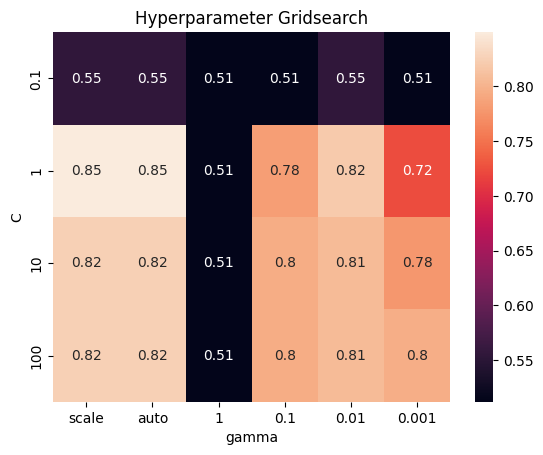

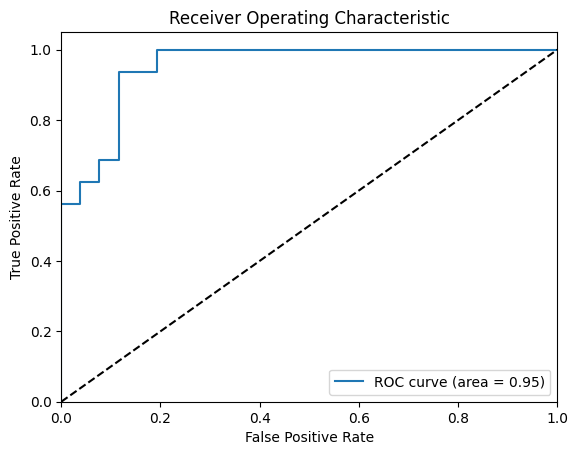

In [9]:
import os
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Set Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'mdshohelrana85'  
os.environ['KAGGLE_KEY'] = 'c7e76d2888a2cf1d2c8be795338b9ced'           

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Define dataset path on Kaggle and local path
kaggle_dataset_path = 'armanakbari/connectionist-bench-sonar-mines-vs-rocks'
local_path = './'

# Download dataset
api.dataset_download_files(kaggle_dataset_path, path=local_path, unzip=True)

# The dataset's name after extraction
csv_file = os.path.join(local_path, 'sonar.all-data.csv')

# Load the dataset
sonar_df = pd.read_csv(csv_file)

# Convert categories 'M' and 'R' to integers
label_encoder = LabelEncoder()
sonar_df['Label'] = label_encoder.fit_transform(sonar_df.iloc[:, -1])  # Assuming the target column is the last one

# Preprocess the data
X = sonar_df.drop(columns=sonar_df.columns[-1])
y = sonar_df.iloc[:, -1]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model and parameters for grid search
model = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001],
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Plot heatmap of the grid search parameters
scores_matrix = grid_search.cv_results_['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))
sns.heatmap(scores_matrix, annot=True, xticklabels=param_grid['gamma'], yticklabels=param_grid['C'])
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('Hyperparameter Gridsearch')
plt.show()

# Comment on results:
# The heatmap shows how accuracy varies with different combinations of C and gamma.
# The best parameters can be visually identified where the score is highest.

# Plot ROC curve for the best model
best_model = grid_search.best_estimator_
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Comment on results:
# The ROC curve and AUC score help evaluate the model's ability to distinguish between classes.
# A higher AUC score indicates a better model performance.

## Task 3 ( 5 points)
##### Dataset: 20 News 
* Number of records: 11314 (train) + 7532 (test)
* Number of features: text
* Repository URL: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

##### Problems
* Concatenate training and testing dataset. Then, cluster 20 News Dataset into 20 clusters. Print true class vs cluster distribution. Did you manage to recover the original clusters? Describe and comment your results. 

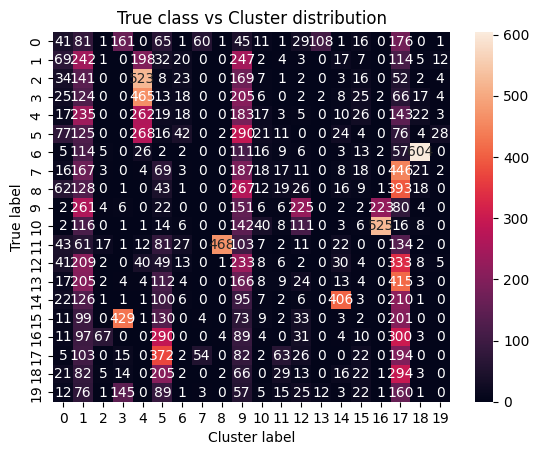

In [10]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, cluster
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
train_data = fetch_20newsgroups(subset='train')
test_data = fetch_20newsgroups(subset='test')

# Concatenate the training and testing data
all_data = train_data.data + test_data.data
all_labels = np.concatenate((train_data.target, test_data.target))

# Preprocess the data: convert the text data into TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(all_data)

# Perform clustering
num_clusters = 20  # As there are 20 newsgroups
kmeans = KMeans(n_clusters=num_clusters, n_init=5, random_state=42)
clusters = kmeans.fit_predict(X)

# Print true class vs cluster distribution
cont_matrix = cluster.contingency_matrix(all_labels, clusters)
sns.heatmap(cont_matrix, annot=True, fmt='d')
plt.xlabel('Cluster label')
plt.ylabel('True label')
plt.title('True class vs Cluster distribution')
plt.show()

# Comment on results:
# The heatmap provides a visual representation of the contingency matrix between true classes and clusters.
# If the clustering perfectly recovered the original clusters, we would expect to see clear blocks along the diagonal.
# However, due to the complexity of the text data, some overlap and spread across clusters are to be expected.